# Installing packages and data, defining functions

In [245]:
from IPython.display import display, Audio
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile
import torch
import torchaudio

In [246]:
labeled_files = pd.read_csv("train_gt (1).csv")

In [247]:
def norm_fft(y, sr=22050, n_fft=2048):
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/sr
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y =  np.fft.fft(y, n_fft)/n # dft and normalization
    Y = Y[:n//2]
    return np.abs(Y)

In [248]:
def freq_to_note(freq, chamber_pitch=440):
    return 12 * np.log2(freq/chamber_pitch) + 69


In [249]:
def get_note(y, n_fft=2048):
    fft = norm_fft(y, n_fft=n_fft)
    freq = fft.max()
    note = freq_to_note(freq)
    return note
    

In [250]:
def set_to_note(y, note, sr=22050, n_fft=2048):
    curr_note = get_note(y, n_fft=2048)
    diff = curr_note - note
    shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=diff)
    return shifted

In [251]:
def std_scale(arr: list):
    arr = np.array(arr)
    return (arr - np.mean(arr)) / np.std(arr)

# EDA

## Melspectograms of defected and non-defected speech


In [33]:
N_SAMPLES = 1
defected_files = labeled_files[labeled_files["Label"] == 1].sample(N_SAMPLES)
no_defects_files = labeled_files[labeled_files["Label"] == 0].sample(N_SAMPLES)

In [257]:
defected_audio, defected_audio_sr = librosa.load(os.path.join("train_audio", defected_files.iloc[0][0]))
l, r = 4.35, 0, len(defected_audio) / defected_audio_sr
print(f"listenting from {l}s to {r}s")
defected_cut = defected_audio[round(l * defected_audio_sr):round(r * defected_audio_sr)]
Audio(defected_cut, rate=defected_audio_sr)

listenting from 0s to 0.16997732426303855s


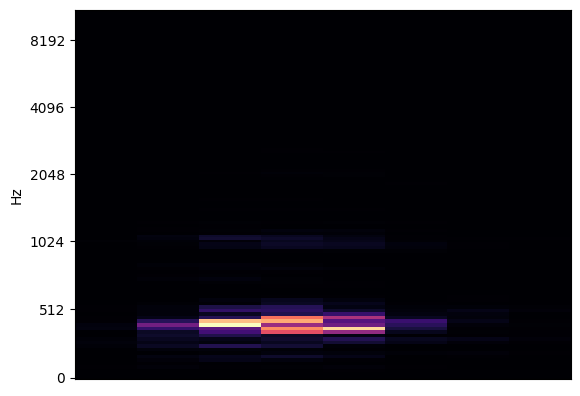

In [258]:
defected_mel = librosa.feature.melspectrogram(y=defected_cut, sr = defected_audio_sr)
defected_mel_db = librosa.power_to_db(np.abs(defected_mel), ref = np.max)
librosa.display.specshow(defected_mel, y_axis="mel")
defected_filename = input()
if defected_filename:
    soundfile.write(f"melspectograms/positives/{defected_filename}.wav", defected_cut, defected_audio_sr)
    plt.savefig(f"melspectograms/positives/{defected_filename}.png")

In [36]:
no_defects_audio, no_defects_audio_sr = librosa.load(os.path.join("train_audio", no_defects_files.iloc[0][0]))
l, r = 0, len(no_defects_audio) / no_defects_audio_sr
print(f"listeting from {l}s to {r}s")
no_defects_cut = no_defects_audio[round(l * no_defects_audio_sr):round(r * no_defects_audio_sr)]
Audio(no_defects_cut, rate=no_defects_audio_sr)

listeting from 0s to 3.24s


/var/folders/5n/f3whpppj2sjg329tk1md_zq80000gn/T/ipykernel_33951/2789279943.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_defects_audio, no_defects_audio_sr = librosa.load(os.path.join("train_audio", no_defects_files.iloc[0][0]))


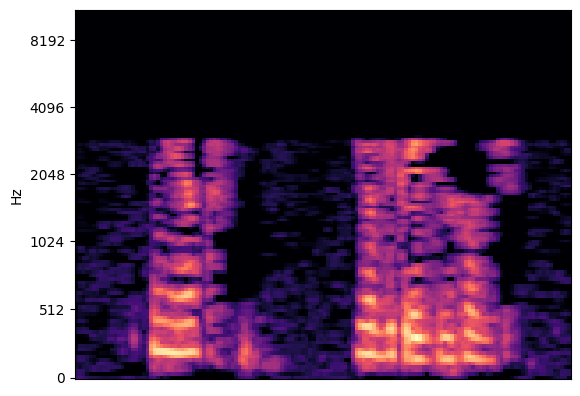

In [37]:
no_defects_mel = librosa.feature.melspectrogram(y=no_defects_cut)
no_defects_mel_db = librosa.power_to_db(np.abs(no_defects_mel), ref = np.max)

librosa.display.specshow(no_defects_mel_db, y_axis="mel")  
no_defects_filename = input()
if no_defects_filename:
    soundfile.write(f"melspectograms/negatives/{no_defects_filename}.wav", no_defects_cut, no_defects_audio_sr)
    plt.savefig(f"melspectograms/negatives/{no_defects_filename}.png")

# Comparing FFTs of audios

In [87]:
std_scale([list(mean_diffs.values())])

array([[0., 0.]])

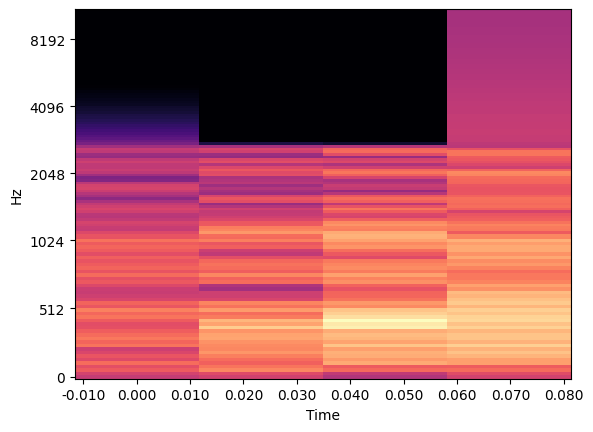

deepmale_burr (MAIN)


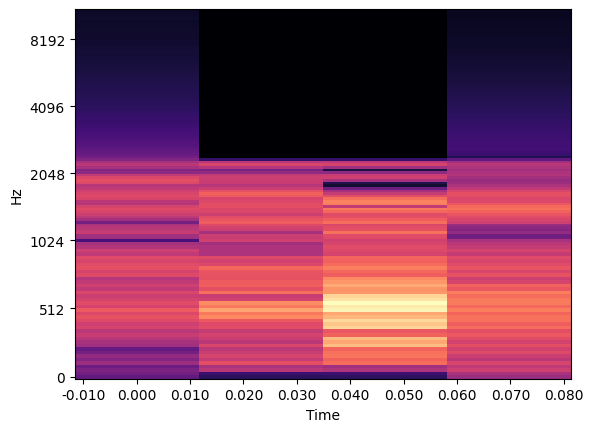

male2_ok


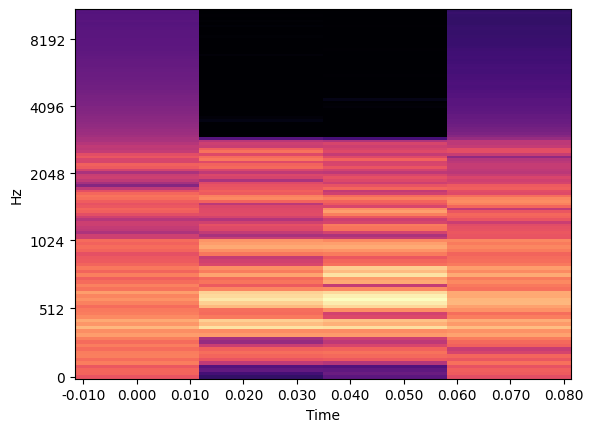

female_ok


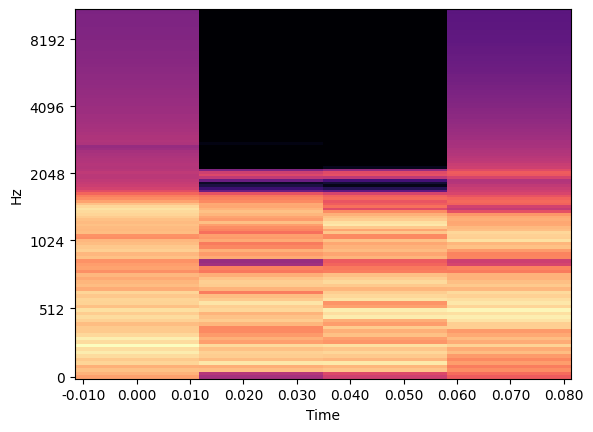

male_burr


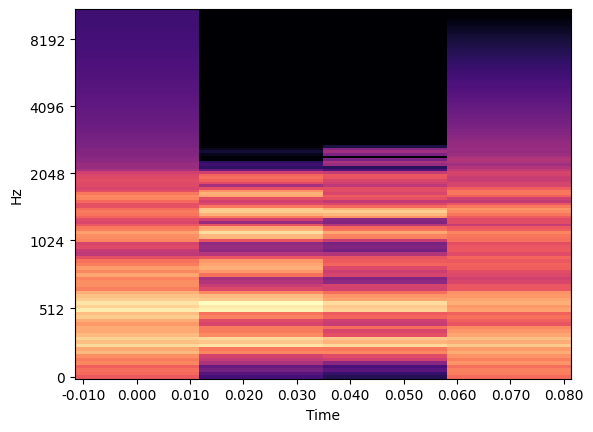

female1_burr


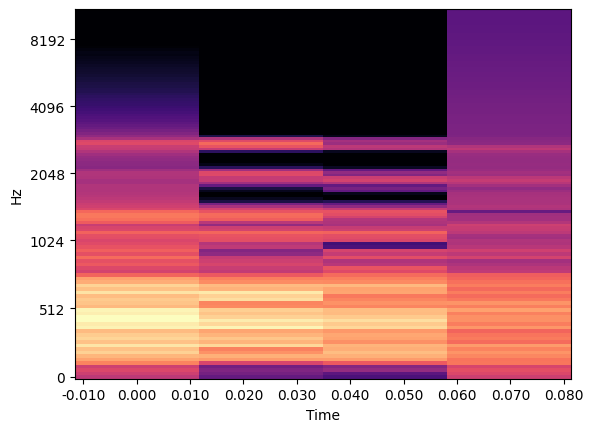

female2_burr


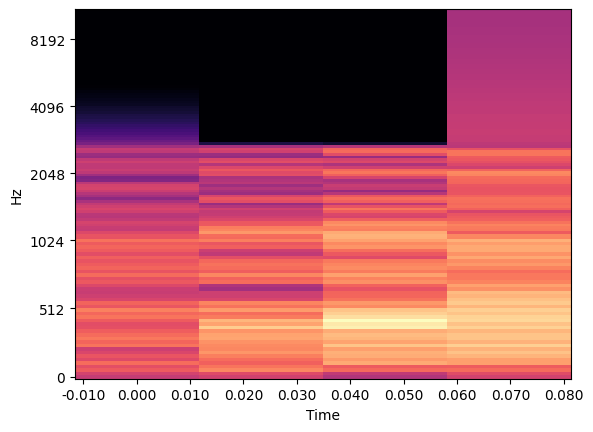

deepmale_burr


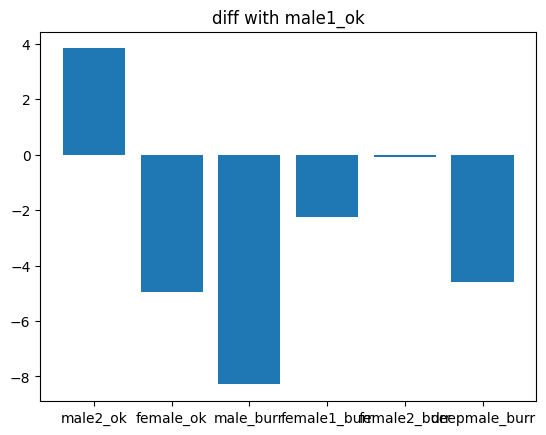

In [266]:
audios = {
"male1_ok": librosa.load("melspectograms/negatives/male.wav")[0],
"male2_ok": librosa.load("melspectograms/negatives/male1.wav")[0],
"female_ok": librosa.load("melspectograms/negatives/female1.wav")[0],
"male_burr": librosa.load("melspectograms/positives/male.wav")[0],
"female1_burr": librosa.load("melspectograms/positives/female.wav")[0],
"female2_burr": librosa.load("melspectograms/positives/female1.wav")[0],
"deepmale_burr": librosa.load("melspectograms/positives/male_deep.wav")[0]
}
diffs = {}
size = min(map(np.size, audios.values()))
for key in audios:
    audios[key] = audios[key][:size]
selecting_main = True
for key, audio in audios.items():
    if selecting_main:
        main_mel = librosa.power_to_db(np.abs(librosa.feature.melspectrogram(y=audio, n_fft=512)), ref=np.max)
        main = (key, 
                main_mel, 
                get_note(audio, n_fft=2048))
        librosa.display.specshow(mel, y_axis="mel", x_axis="time")
        plt.show()
        display(Audio(audio, rate=sr))
        print(label + " (MAIN)")
        selecting_main = False
        soundfile.write(f"main {key}.wav", audio, sr)
        continue
    shifted = audio#set_to_note(audio, main[2], n_fft=2048)
    soundfile.write(f"shifted {key}.wav", shifted, sr)
    mel = librosa.power_to_db(np.abs(librosa.feature.melspectrogram(y=shifted, n_fft=512)), ref=np.max)
    diff = main[1] - mel
    label = key
    diffs[label] = diff
    librosa.display.specshow(mel,y_axis="mel", x_axis="time")
    plt.show()
    display(Audio(audio, rate=sr))
    print(label)
mean_diffs = {key : np.mean(diff) for key, diff in diffs.items()}
plt.bar(mean_diffs.keys(), (list(mean_diffs.values())))
plt.title(f"diff with {main[0]}")
plt.show()